Plotting Albedo Trend...


/share/home/dynamo2/wangyu/.conda/envs/meteo_env/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1646: UserWarning: The following kwargs were not used by contour: 'add_colorbar', 'add_labels'
  result = super().contourf(*args, **kwargs)


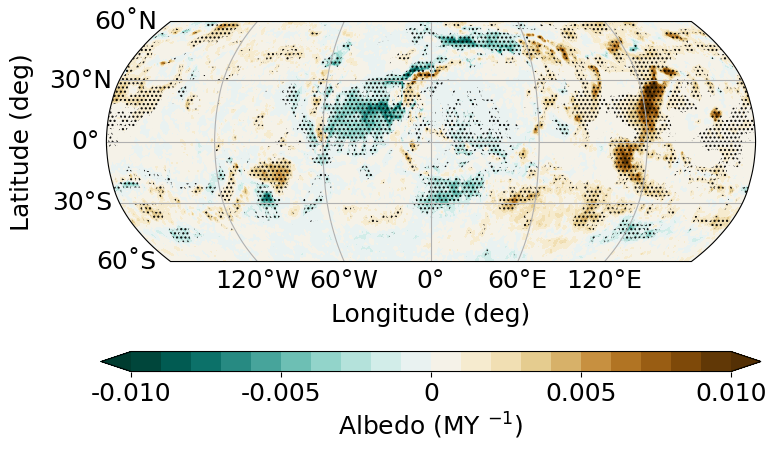

Plotting Thermal Inertia Trend...


/share/home/dynamo2/wangyu/.conda/envs/meteo_env/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1646: UserWarning: The following kwargs were not used by contour: 'add_colorbar', 'add_labels'
  result = super().contourf(*args, **kwargs)


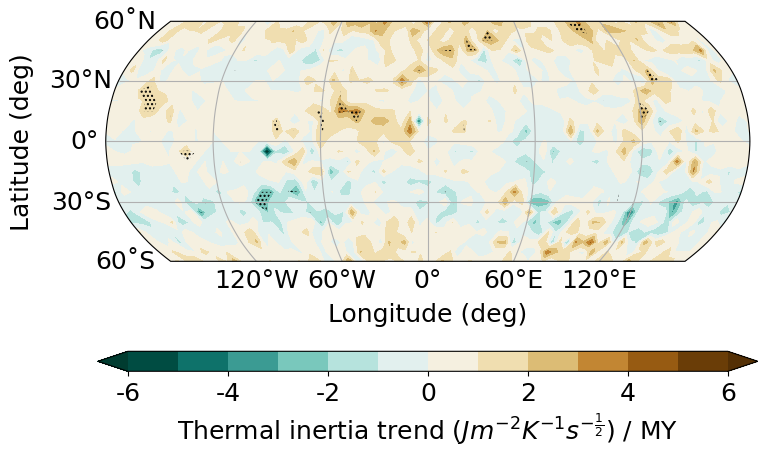

Plotting Dust Trend...


/share/home/dynamo2/wangyu/.conda/envs/meteo_env/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1646: UserWarning: The following kwargs were not used by contour: 'add_colorbar', 'add_labels'
  result = super().contourf(*args, **kwargs)


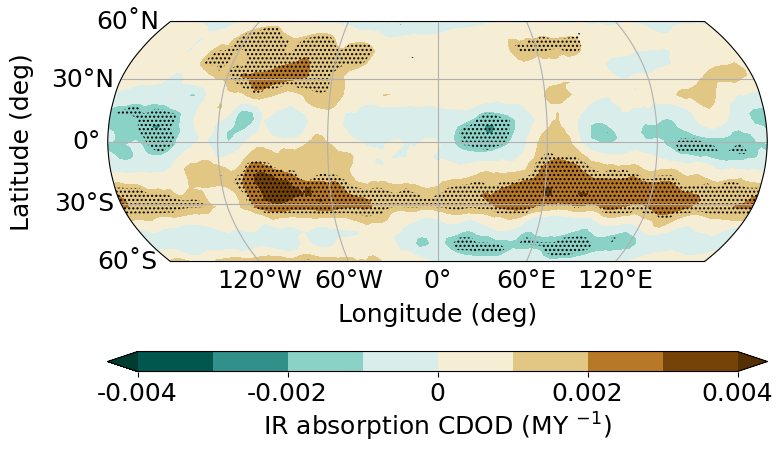

In [ ]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point

# ==========================================
# Configuration: Paths and Plot Settings
# ==========================================

# Base path for data files
BASE_PATH = '../archive/data/'

# Plot configurations for each variable
PLOT_CONFIGS = {
    'albedo': {
        'filename': 'albedo_trend_2d.nc',
        'levels': np.arange(-0.01, 0.011, 0.001),
        'vmin': -0.01,
        'vmax': 0.01,
        'cbar_ticks': np.arange(-0.01, 0.011, 0.005),
        'cbar_labels': ['-0.010', '-0.005', '0', '0.005', '0.010'],
        'xlabel': 'Albedo (MY $^{-1}$)'
    },
    'thermal_inertia': {
        'filename': 'ti_trend_2d.nc',
        'levels': np.arange(-6, 6.5, 1),
        'vmin': -6,
        'vmax': 6,
        'cbar_ticks': np.arange(-6, 6.5, 2),
        'cbar_labels': [f'{x:1.0f}' for x in np.arange(-6, 6.5, 2)],
        'xlabel': r'Thermal inertia trend ($Jm^{-2}K^{-1}s^{- \frac{1}{2}}$) / MY'
    },
    'dust': {
        'filename': 'dust_trend_2d.nc',
        'levels': np.arange(-0.004, 0.0041, 0.001),
        'vmin': -0.004,
        'vmax': 0.004,
        'cbar_ticks': np.arange(-0.004, 0.0041, 0.002),
        'cbar_labels': ['-0.004', '-0.002', '0', '0.002', '0.004'],
        'xlabel': 'IR absorption CDOD (MY $^{-1}$)'
    }
}

# ==========================================
# Core Plotting Functions
# ==========================================

def setup_robinson_axes(fig, pos):
    """
    Initializes a subplot with Robinson projection and specific formatting constraints.
    """
    ax = fig.add_axes(pos, projection=ccrs.Robinson())
    
    # Gridlines setup
    gl = ax.gridlines(draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 18}
    gl.ylabel_style = {'size': 18}
    gl.xlocator = mticker.FixedLocator(np.arange(-120, 180, 60))
    gl.ylocator = mticker.FixedLocator(np.arange(-60, 61, 30))

    # Manual labels as per original requirement
    ax.text(0.03, 1.0, '60˚N', ha='center', va='center', transform=ax.transAxes, fontsize=18)
    ax.text(0.03, 0.0, '60˚S', ha='center', va='center', transform=ax.transAxes, fontsize=18)
    ax.text(0.5, -0.22, 'Longitude (deg)', ha='center', va='center', transform=ax.transAxes, fontsize=18)
    ax.text(-0.13, 0.5, 'Latitude (deg)', ha='center', va='center', transform=ax.transAxes, fontsize=18, rotation='vertical')

    # Tick params
    ax.tick_params('both', which='both', top=False, right=False, labelsize=18)
    
    return ax

def plot_trend_map(config_key):
    """
    Loads data and creates the figure for a specific configuration key (albedo, thermal_inertia, or dust).
    """
    cfg = PLOT_CONFIGS[config_key]
    
    # 1. Load Data
    file_path = f"{BASE_PATH}{cfg['filename']}"
    try:
        ds = xr.open_dataset(file_path)
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        return

    slope = ds['slope']
    p_value = ds['p_value']

    # Select Lat/Lon ranges
    # Note: Sorting lat ensures consistency regardless of input file storage order
    lon = slope['longitude'].loc[-180:180]
    lat = slope['latitude'].loc[-60:60] 
    
    # Apply Cyclic Point (to close the gap at 180/-180)
    cycle_slope, cycle_lon = add_cyclic_point(slope.loc[{'latitude': lat, 'longitude': lon}], coord=lon)
    cycle_p_value, _ = add_cyclic_point(p_value.loc[{'latitude': lat, 'longitude': lon}], coord=lon)

    # 2. Setup Figure
    fig = plt.figure(figsize=(20, 20))
    
    # Axis Position [left, bottom, width, height]
    ax = setup_robinson_axes(fig, [0.12, 0.70, 0.4, 0.12])

    # 3. Plot Contours
    contourf_kw = dict(
        transform=ccrs.PlateCarree(),
        levels=cfg['levels'],
        cmap=mpl.cm.BrBG_r,
        add_colorbar=False,
        add_labels=False,
        vmin=cfg['vmin'],
        vmax=cfg['vmax'],
        extend='both',
        zorder=0
    )

    c1 = ax.contourf(cycle_lon, lat, cycle_slope, **contourf_kw)

    # 4. Plot Significance Hatching
    ax.contourf(cycle_lon, lat, cycle_p_value, [0, 0.005, 1], 
                zorder=1, hatches=['....', None], colors="none", 
                transform=ccrs.PlateCarree())

    # 5. Add Colorbar
    cbar_pos = fig.add_axes([0.155, 0.645, 0.33, 0.01])
    cb = fig.colorbar(c1, cax=cbar_pos, orientation='horizontal')
    
    cb.ax.set_xticks(cfg['cbar_ticks'])
    cb.ax.set_xticklabels(cfg['cbar_labels'])
    cb.ax.set_xlabel(cfg['xlabel'], fontsize=18) # Note: TI code had 16, others 18. Standardized to 18 based on majority.
    plt.setp(cb.ax.get_xticklabels(), fontsize=18)

    plt.show()

# ==========================================
# Execution
# ==========================================

if __name__ == "__main__":
    # You can loop through keys or call them individually
    
    print("Plotting Albedo Trend...")
    plot_trend_map('albedo')
    
    print("Plotting Thermal Inertia Trend...")
    plot_trend_map('thermal_inertia')
    
    print("Plotting Dust Trend...")
    plot_trend_map('dust')